In [310]:
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import properties as prop
import random_initialization as rand_init
import matrixes as ma
import interblock_matrixes as i_ma
import utils as u

imp.reload(prop)
imp.reload(rand_init)
imp.reload(ma)
imp.reload(i_ma)
imp.reload(u)

const = prop.Constants()

In [311]:
ns = 50000
x_min, x_max = -1.3, 1.3
y_min, y_max = -1.3, 1.3
nx , ny = 5, 5

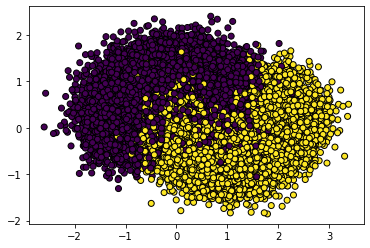

In [312]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.4)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()

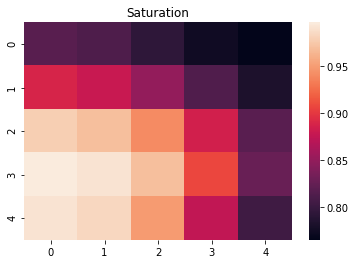

In [313]:
Satur_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=1, x_min=-1,
                                                 y_min=-1, y_max=1, n_x=nx, n_y=ny
                                                )
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

In [314]:
assert np.isnan(Satur_matrix).sum() == 0

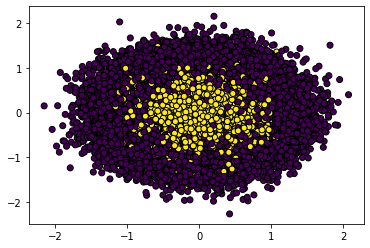

In [315]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()  

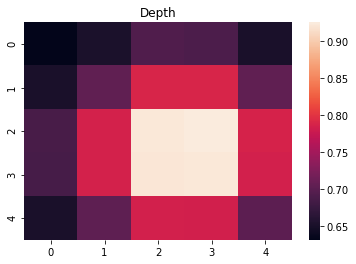

In [316]:
depth_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max, n_x=nx, n_y=ny
                                                )
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

In [317]:
assert np.isnan(depth_matrix).sum() == 0

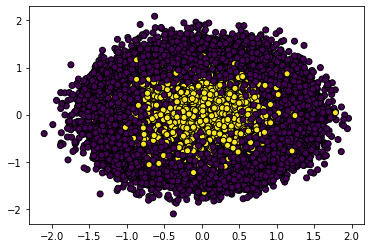

In [318]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()   

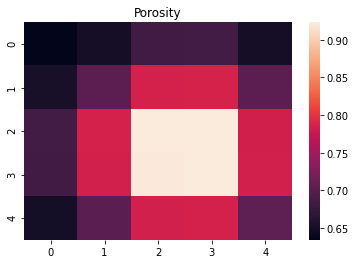

In [319]:
porosity_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max, n_x=nx, n_y=ny
                                                )
sns.heatmap(porosity_matrix)
plt.title("Porosity")
plt.show()

In [320]:
assert np.isnan(porosity_matrix).sum() == 0

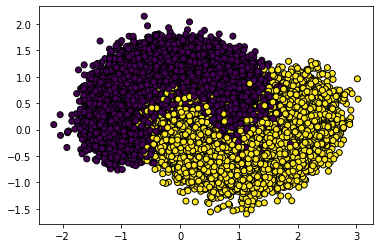

In [321]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.3)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show() 

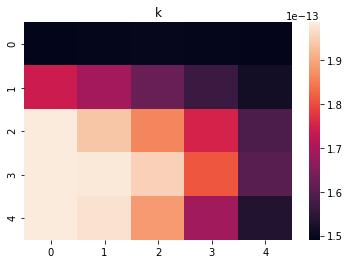

In [322]:
k_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max-0.1, x_min=x_min+0.1,
                                             y_min=y_min+0.1, y_max=y_max-0.1, n_x=nx, n_y=ny
                                            )
k_matrix *= const.k_avg()
sns.heatmap(k_matrix)
plt.title("k")
plt.show()

In [323]:
assert np.isnan(k_matrix).sum() == 0

Давления пусть будут одинаково распределены

In [324]:
dy = np.ones(ny) * const.dy()
dx = np.ones(nx) * const.dx()

p_vec = np.ones((nx*ny)) * const.p_0()
S_o_vec = Satur_matrix.reshape(-1)
S_w_vec = (np.ones(Satur_matrix.shape) - Satur_matrix).reshape(-1)

Обозначем важные прмежуточные матрицы для 
$$\vec{p^{n+1}} = \vec{p^{n}} + \Delta t \big[B^{p, w}\big]^{-1}\big[ T^{upd}_{\tilde{k}} \vec{p} + \tilde{Q} + \frac{B_o}{B_w} q_o^{well} + q_w^{well}\big]$$

In [325]:
b_p_w = ma.get_b_p_w(porosity_matrix, const)
depth_m = i_ma.DMatrix(depth_matrix)
k_matrix_0 = i_ma.KMatrix(k_values=k_matrix,
                         dy_matrix=dy,
                         dx_matrix=dx)
k_tilde = ma.get_k_tilde(consts=const, k=k_matrix_0)
t_k_tilde = i_ma.TInterBlockMatrix(k_matrix=k_tilde,
                                      dx_matrix=dx,
                                      dy_matrix=dy, 
                                      d_matrix=depth_m)
t_upd_k_tilde = ma.get_t_upd_matrix(t_k_tilde)

In [326]:
b_s_o = ma.get_b_s_o(consts=const, porosity=porosity_matrix)
k_s_o = ma.get_k_s_o(consts=const, k=k_matrix_0)
t_k_s_o = i_ma.TInterBlockMatrix(k_matrix=k_s_o,
                                      dx_matrix=dx,
                                      dy_matrix=dy, 
                                      d_matrix=depth_m)
t_upd_k_s_o = ma.get_t_upd_matrix(t_k_s_o)

In [327]:
b_s_w = ma.get_b_s_o(consts=const, porosity=porosity_matrix)
k_s_w = ma.get_k_s_w(consts=const, k=k_matrix_0)
t_k_s_w = i_ma.TInterBlockMatrix(k_matrix=k_s_w,
                                      dx_matrix=dx,
                                      dy_matrix=dy, 
                                      d_matrix=depth_m)
t_upd_k_s_w = ma.get_t_upd_matrix(t_k_s_w)

In [328]:
dict_wells = {u.two_dim_index_to_one(i=2, j = 2, ny=ny): -0.1
             }

In [329]:
b_rat = const.b_o() / const.b_w()
q_w, q_o = ma.get_q_well(dict_wells,s_w=S_w_vec, s_o=S_o_vec, nx=nx, ny=ny)
bpw_inv = ma.inverse_diag(b_p_w)
por_mat_diag = np.diag(porosity_matrix.reshape(-1))
por_inv = ma.inverse_diag(por_mat_diag)
v_matrix = np.diag(const.dx() * const.dy() * depth_matrix.reshape(-1))
v_matrix_inv = ma.inverse_diag(v_matrix)

In [330]:
tri_matr_o = ma.diagonal_multidot([por_inv, b_s_o, v_matrix_inv])
tri_matr_w = ma.diagonal_multidot([por_inv, b_s_w, v_matrix_inv])

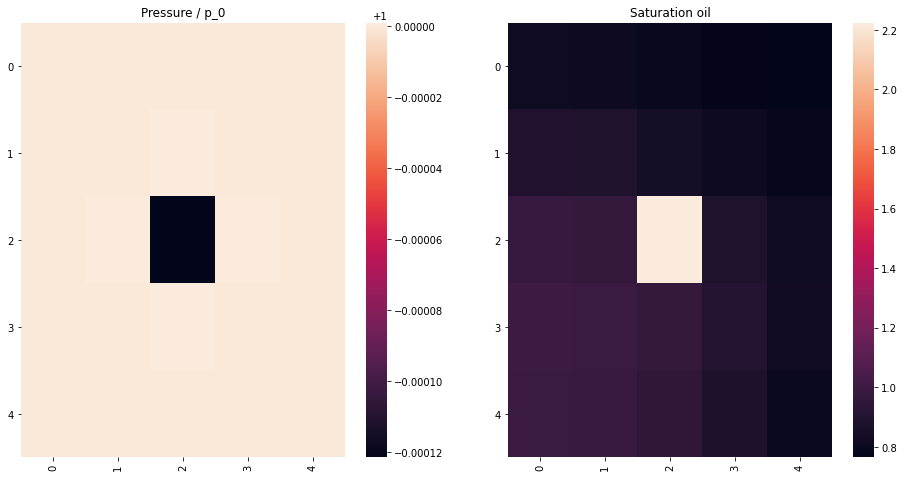

In [341]:
for i in range(int(1)):
    q_tilde = ma.get_q_bound(t_k_tilde, const.p_0(), p_vec)
    q_w, q_o = ma.get_q_well(dict_wells, s_w=S_w_vec, s_o=S_o_vec, nx=nx, ny=ny)
    
    p_vec_new = p_vec + const.dt() * bpw_inv.dot(t_upd_k_tilde.dot(p_vec) + q_tilde + b_rat * q_o  + q_w)

    S_o_vec_new = S_o_vec - tri_matr_o.dot(p_vec_new - p_vec) * const.b_o() 
    S_o_vec_new += const.dt() * const.b_o() * por_inv.dot(t_upd_k_s_o.dot(p_vec_new) + q_o)

    S_w_vec_new = S_w_vec - tri_matr_w.dot(p_vec_new - p_vec) * const.b_w() 
    S_w_vec_new += const.dt() * const.b_w() * por_inv.dot(t_upd_k_s_w.dot(p_vec_new) + q_w)
    
    p_vec = p_vec_new
    S_o_vec = S_o_vec_new
    S_w_vec = S_w_vec_new
    if i % 50 == 0:  
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
        ax[0].get_shared_y_axes().join(ax[1])
        g1 = sns.heatmap(p_vec_new.reshape(nx, ny) / const.p_0(), ax=ax[0])
        g1.set_title('Pressure / p_0')
        g2 = sns.heatmap(S_o_vec.reshape(nx, ny), ax=ax[1])
        g2.set_title('Saturation oil')

        # may be needed to rotate the ticklabels correctly:
        for _ax in [g1,g2]:
            tl = _ax.get_xticklabels()
            _ax.set_xticklabels(tl, rotation=90)
            tly = _ax.get_yticklabels()
            _ax.set_yticklabels(tly, rotation=0)

        plt.show()

In [332]:
p_vec_new[12] / const.p_0()

0.9999803574259214

In [333]:
S_w_vec_new[12] / const.p_0()

1.8342045292477702e-10

<AxesSubplot:>

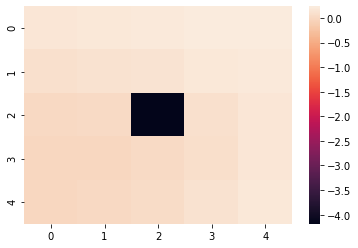

In [342]:
sns.heatmap(S_w_vec.reshape(nx, ny))

In [335]:
S_w_vec[12]

0.050580024098536513

In [336]:
q_tilde = ma.get_q_bound(t_k_tilde, const.p_0(), p_vec)
q_w, q_o = ma.get_q_well(dict_wells, s_w=S_w_vec, s_o=S_o_vec, nx=nx, ny=ny)
    
p_vec_new = p_vec + const.dt() * bpw_inv.dot(t_upd_k_tilde.dot(p_vec) + q_tilde + b_rat * q_o  + q_w)

S_o_vec_new = S_o_vec - tri_matr_o.dot(p_vec_new - p_vec) * const.b_o() 
S_o_vec_new += const.dt() * const.b_o() * por_inv.dot(t_upd_k_s_o.dot(p_vec_new) + q_o)

S_w_vec_new = S_w_vec - tri_matr_w.dot(p_vec_new - p_vec) * const.b_w() 
S_w_vec_new += const.dt() * const.b_w() * por_inv.dot(t_upd_k_s_w.dot(p_vec_new) + q_w)